In [160]:
import pandas as pd
import numpy as np
import  datetime
from matplotlib import pyplot as plt
from scipy import stats

import pylab 

# Задача 1 - Знакомство с данными:

## загрузить датасет

In [2]:
df = pd.read_csv('export_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28085 entries, 0 to 28084
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              28085 non-null  int64  
 1   rra_id                  28085 non-null  int64  
 2   rra_playerId            28085 non-null  int64  
 3   rra_dateAt              28085 non-null  object 
 4   rra_partnerId           28085 non-null  int64  
 5   rra_brandId             28085 non-null  int64  
 6   rra_campaignId          28085 non-null  int64  
 7   rra_playerCountry       28085 non-null  object 
 8   rra_registrationsCount  28085 non-null  int64  
 9   rra_depositsCount       28085 non-null  int64  
 10  firstDepositsSumEur     28085 non-null  float64
 11  depositsSumEur          28085 non-null  float64
 12  c_registrationDateAt    28085 non-null  object 
 13  c_gender                28085 non-null  object 
 14  c_age                   28085 non-null

In [4]:
df.describe()

,Unnamed: 0,rra_id,rra_playerId,rra_partnerId,rra_brandId,rra_campaignId,rra_registrationsCount,rra_depositsCount,firstDepositsSumEur,depositsSumEur,c_age
count,28085.000000,2.808500e+04,2.808500e+04,28085.000000,28085.000000,28085.000000,28085.000000,28085.000000,28085.000000,28085.000000,28085.000000
mean,153317.849706,3.321866e+17,5.481566e+06,86025.884636,100.504219,98327.196724,0.186363,1.257896,7.693112,68.369253,35.097953
std,73626.934611,2.143594e+17,8.289298e+04,2216.994036,1.500021,3320.925846,0.389406,1.920410,22.937528,413.336827,10.944005
min,58.000000,1.000037e+17,5.346033e+06,82464.000000,99.000000,87197.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,128776.000000,1.923436e+17,5.408485e+06,84181.000000,99.000000,95158.000000,0.000000,0.000000,0.000000,0.000000,27.000000
50%,185961.000000,2.830312e+17,5.479516e+06,86068.000000,102.000000,99793.000000,0.000000,1.000000,0.000000,20.000000,33.000000
75%,194031.000000,3.144589e+17,5.551333e+06,88092.000000,102.000000,101473.000000,0.000000,1.000000,0.000000,50.000000,42.000000
max,267383.000000,9.999041e+17,5.638164e+06,89890.000000,102.000000,103594.000000,1.000000,46.000000,1000.000000,52500.000000,112.000000


## выбрать 4 когорты пользователей, в соответствии с 4 неделями сентября и сопоставить их,

In [5]:
#Добавляем поля дата и дата регистрации
df['date']=pd.to_datetime(df.rra_dateAt).dt.date
df['reg_date'] = pd.to_datetime(df['c_registrationDateAt']).dt.date
#Разбиваем пользователей по когортам
df['reg_week'] = 4
df.loc[df['reg_date']<datetime.date(2020, 9, 23),'reg_week'] = 3
df.loc[df['reg_date']<datetime.date(2020, 9, 16),'reg_week'] = 2
df.loc[df['reg_date']<datetime.date(2020, 9, 9),'reg_week'] = 1

In [6]:
def date_user_active_joined_calc(dataset, cog=None):
##Cоздаем табличку активности пользователей по датам
    if cog is None:
        df = dataset
    else:
        df=dataset.loc[dataset['reg_week']==cog]
    
    
#Создаем таблицу с минимальной и максимальной датой активности по пользователям
    players_min_dates = df.groupby('rra_playerId')['date'].min().reset_index()
    players_max_dates = df.groupby('rra_playerId')['date'].max().reset_index()
    players_min_max = pd.merge(players_min_dates,players_max_dates, on ='rra_playerId')
#Создаем таблицу с уникальными датами
    dates = pd.DataFrame(df.date.unique(), columns=['date'])
#Добавляем технический ключ для кросс джоина
    players_min_max['key'] = 1
    dates['key'] = 1
#Объединяем таблицы в одну, удаляя строки, где дата меньше первой активности пользователя
    cross_tab = pd.merge(dates,players_min_max, on = 'key').drop(columns=['key'])
    cross_tab = cross_tab.loc[cross_tab['date']>=cross_tab['date_x']]
#Добавляем флаг активности пользователям
    cross_tab['is_active'] = \
    (cross_tab['date_x']<=cross_tab['date'])\
    &(cross_tab['date']<=cross_tab['date_y'])
#Добавляем флаг присоединения пользователя
    cross_tab['joined_flg'] = \
    (cross_tab['date']==cross_tab['date_x'])


#Создаем что то вроде справочников
    platforms = df.groupby('rra_playerId')['rra_brandId'].mean() #Проверил, связь между игроками и брендами платформ 1 к 1, т.о можно использовать любую агрегацию
    countries = df.groupby('rra_playerId')['rra_playerCountry'].max()
    genders = df.groupby('rra_playerId')['c_gender'].max()
    ages = df.groupby('rra_playerId')['c_age'].max()
    partners = df.groupby('rra_playerId')['rra_partnerId'].max()
    campaigns = df.groupby('rra_playerId')['rra_campaignId'].max()
    reg_week = df.groupby('rra_playerId')['reg_week'].max()
    dep_sum = df.groupby(['date', 'rra_playerId'])['depositsSumEur'].sum()
    first_dep = df.groupby(['date', 'rra_playerId'])['firstDepositsSumEur'].sum()
    dep_cnt = df.groupby(['date', 'rra_playerId'])['rra_depositsCount'].sum()
#Присоединяем "справочники"
    cross_tab = pd.merge(cross_tab,countries, on = 'rra_playerId',how = 'left')
    cross_tab = pd.merge(cross_tab,platforms, on = 'rra_playerId',how = 'left')
    cross_tab = pd.merge(cross_tab,genders, on = 'rra_playerId',how = 'left')
    cross_tab = pd.merge(cross_tab,partners, on = 'rra_playerId',how = 'left')
    cross_tab = pd.merge(cross_tab,campaigns, on = 'rra_playerId',how = 'left')
    cross_tab = pd.merge(cross_tab,ages, on = 'rra_playerId',how = 'left')
    cross_tab = pd.merge(cross_tab,reg_week, on = 'rra_playerId',how = 'left')
    cross_tab = pd.merge(cross_tab,dep_sum, on = ['date','rra_playerId'], how = 'left')
    cross_tab = pd.merge(cross_tab,first_dep, on = ['date','rra_playerId'], how = 'left')
    cross_tab = pd.merge(cross_tab,dep_cnt, on = ['date','rra_playerId'], how = 'left')

    
    
    return cross_tab.replace({False:0,True:1}).fillna(0)

In [7]:
def agregated(cross_tab):
##Создаем табличку с количествами активных, оттекших и добавившихся пользователей cr и rr
#cчитаем количество активных и неактивных пользователей
    active_churn = cross_tab\
    .groupby(['date', 'is_active'])[['rra_playerId','depositsSumEur']]\
    .agg({'rra_playerId':'nunique','depositsSumEur':'sum'}).unstack().reset_index()

    active_churn.columns=['date','inactive_cnt','active_cnt','drop','dep_sum']
    active_churn = active_churn.drop(columns='drop')

#active_churn.columns = ['date',  'churn_cnt', 'active_players_cnt']
    active_churn = active_churn.fillna(0)
#cчитаем количество новыъ и старых пользователей
    old_new = cross_tab\
    .groupby(['date', 'joined_flg'])[['rra_playerId']]\
    .nunique().unstack().reset_index()
    old_new.columns = ['date',  'old', 'new']
    old_new=old_new.fillna(0)
#Объединяем таблицы
    data = pd.merge(active_churn,old_new,on='date')

#Расчитываем дополнительные показатели
    data['ARPU(act)']=data['dep_sum']/data['active_cnt']
    data['ARPU(all)']=data['dep_sum']/(data['active_cnt']+data['inactive_cnt'])
    data['cr_d']=(data['active_cnt'].shift(1)-(data['active_cnt']-data['new']))/data['active_cnt'].shift(1)
    data['rr_d']=1-data['cr_d']
    
    data['cumulative_cr'] = data['inactive_cnt']/(data['old'])
    data['cumulative_rr'] = 1-data['cumulative_cr']
    
    data['']

    return data

In [8]:
cog1 = agregated(date_user_active_joined_calc(df,1))
cog2 = agregated(date_user_active_joined_calc(df,2))
cog3 = agregated(date_user_active_joined_calc(df,3))
cog4 = agregated(date_user_active_joined_calc(df,4))

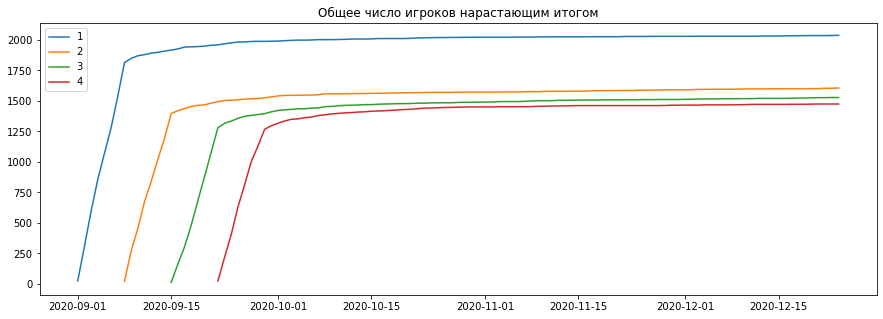

In [21]:
plt.figure(figsize=(15, 5))
plt.title('Общее число игроков нарастающим итогом')
plt.plot(cog1['date'],cog1['active_cnt']+cog1['inactive_cnt'],label=1)
plt.plot(cog2['date'],cog2['active_cnt']+cog2['inactive_cnt'],label=2)
plt.plot(cog3['date'],cog3['active_cnt']+cog3['inactive_cnt'],label=3)
plt.plot(cog4['date'],cog4['active_cnt']+cog4['inactive_cnt'],label=4)
plt.legend()
plt.show()

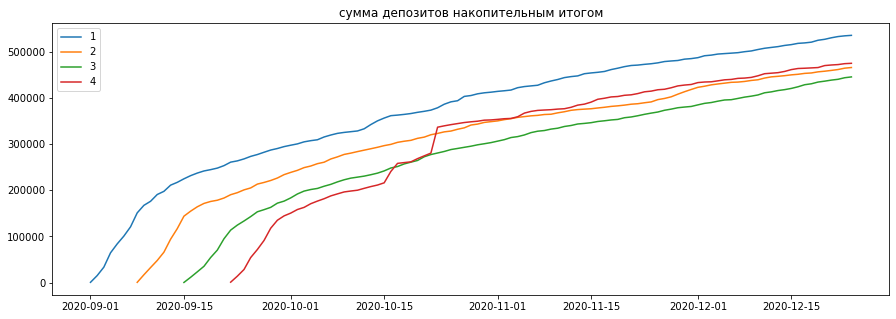

In [31]:
plt.figure(figsize=(15, 5))
plt.title('сумма депозитов накопительным итогом')
plt.plot(cog1['date'],cog1['dep_sum'].cumsum(),label=1)
plt.plot(cog2['date'],cog2['dep_sum'].cumsum(),label=2)
plt.plot(cog3['date'],cog3['dep_sum'].cumsum(),label=3)
plt.plot(cog4['date'],cog4['dep_sum'].cumsum(),label=4)
plt.legend()
plt.show()

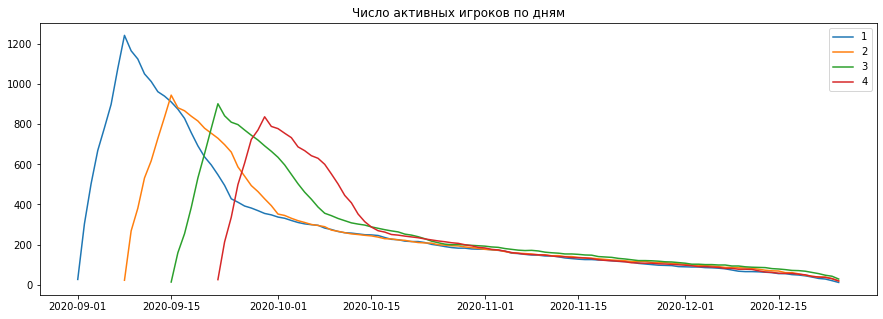

In [23]:
plt.figure(figsize=(15, 5))
plt.title('Число активных игроков по дням')
plt.plot(cog1['date'],cog1['active_cnt'],label=1)
plt.plot(cog2['date'],cog2['active_cnt'],label=2)
plt.plot(cog3['date'],cog3['active_cnt'],label=3)
plt.plot(cog4['date'],cog4['active_cnt'],label=4)
plt.legend()
plt.show()

## рассчитать покогортно средний чек - ARPU (в качестве revenue - взять depositsSumEur),

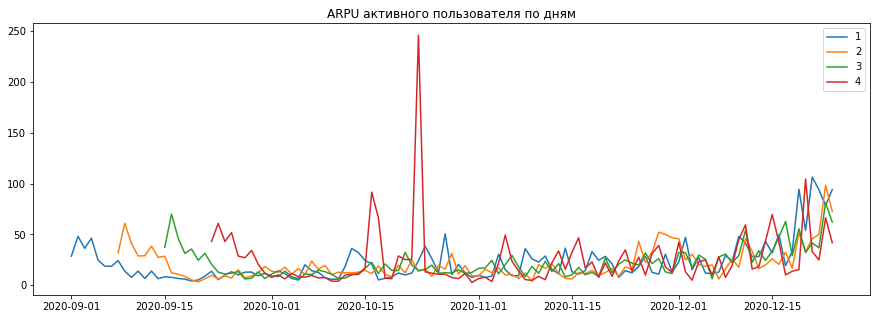

In [26]:
plt.figure(figsize=(15, 5))
plt.title('ARPU активного пользователя по дням')
plt.plot(cog1['date'],cog1['ARPU(act)'],label=1)
plt.plot(cog2['date'],cog2['ARPU(act)'],label=2)
plt.plot(cog3['date'],cog3['ARPU(act)'],label=3)
plt.plot(cog4['date'],cog4['ARPU(act)'],label=4)
plt.legend()
plt.show()

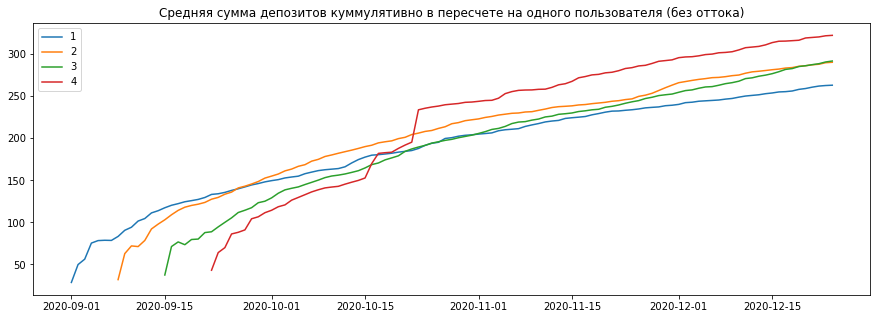

In [83]:
plt.figure(figsize=(15, 5))
plt.title('Средняя сумма депозитов куммулятивно в пересчете на одного пользователя (без оттока)')
plt.plot(cog1['date'],cog1['dep_sum'].cumsum()/(cog1['old']+cog1['new']),label=1)
plt.plot(cog2['date'],cog2['dep_sum'].cumsum()/(cog2['old']+cog2['new']),label=2)
plt.plot(cog3['date'],cog3['dep_sum'].cumsum()/(cog3['old']+cog3['new']),label=3)
plt.plot(cog4['date'],cog4['dep_sum'].cumsum()/(cog4['old']+cog4['new']),label=4)
plt.legend()
plt.show()

## сравнить пользователей покогортно по странам/платформе

In [40]:
#Определяем по пять самых больших по числу пользователей стран на каждую когорту
a = df.groupby(['reg_week','rra_playerCountry'])[['rra_playerId']].nunique()
g = a['rra_playerId'].groupby('reg_week', group_keys=False)
top_countries = g.nlargest(5).reset_index()
top_countries

,reg_week,rra_playerCountry,rra_playerId
0,1,AU,803
1,1,NL,609
2,1,NO,180
3,1,FI,120
4,1,DE,112
5,2,AU,528
6,2,NL,503
7,2,NO,134
8,2,FI,133
9,2,DE,130


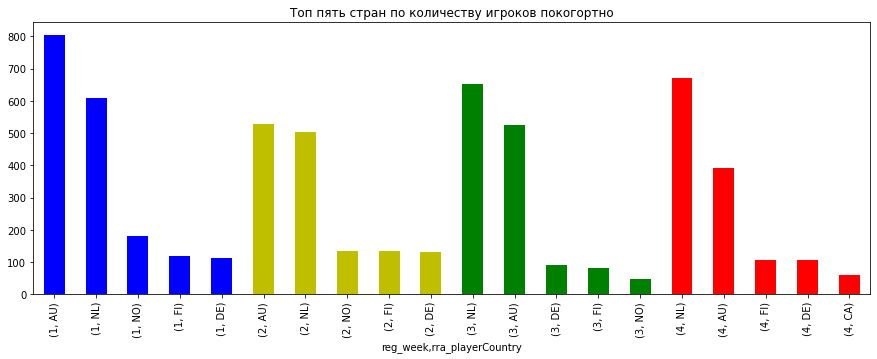

In [41]:
g.nlargest(5).plot.bar(figsize=(15,5),color = ['b']*5+['y']*5+['g']*5+['r']*5, title = 'Топ пять стран по количеству игроков покогортно')

In [42]:
#то же самое но по платформе
a = df.groupby(['reg_week','rra_brandId'])[['rra_playerId']].nunique()
g = a['rra_playerId'].groupby('reg_week', group_keys=False)
top = g.nlargest(5).reset_index()
top

,reg_week,rra_brandId,rra_playerId
0,1,99,1100
1,1,102,936
2,2,102,831
3,2,99,774
4,3,102,876
5,3,99,651
6,4,102,924
7,4,99,550


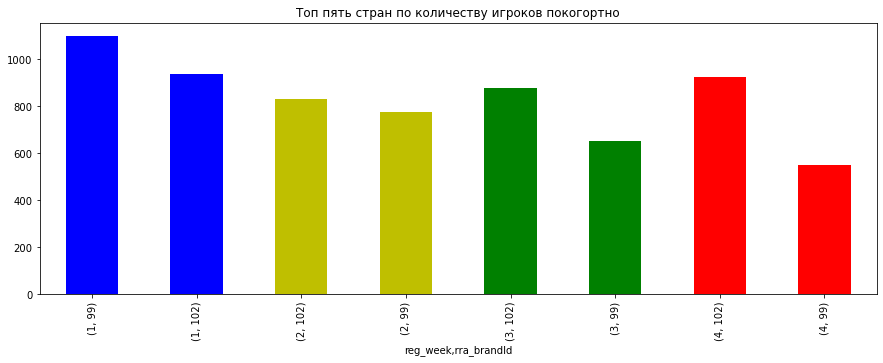

In [45]:
g.nlargest(5).plot.bar(figsize=(15,5),color = ['b']*2+['y']*2+['g']*2+['r']*2, title = 'Топ пять стран по количеству игроков покогортно')

# Задача 2 - EDA

## вытащить любые инсайты из данных (распределение по полу, возрасту, странам)

##### Распределение по полу

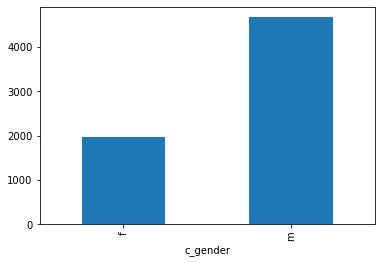

In [84]:
df.groupby(['c_gender'])['rra_playerId'].nunique().plot.bar()

In [96]:
m = agregated(date_user_active_joined_calc(df.loc[df['c_gender']=='m'])).sort_values(by='date')

In [97]:
f = agregated(date_user_active_joined_calc(df.loc[df['c_gender']=='f']))

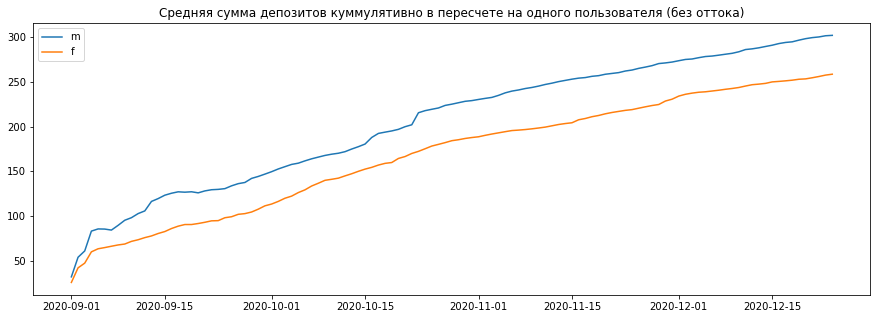

In [98]:
plt.figure(figsize=(15, 5))
plt.title('Средняя сумма депозитов куммулятивно в пересчете на одного пользователя (без оттока)')
plt.plot(m['date'],m['dep_sum'].cumsum()/(m['active_cnt']+m['inactive_cnt']),label='m')
plt.plot(f['date'],f['dep_sum'].cumsum()/(f['active_cnt']+f['inactive_cnt']),label='f')
plt.legend()
plt.show()

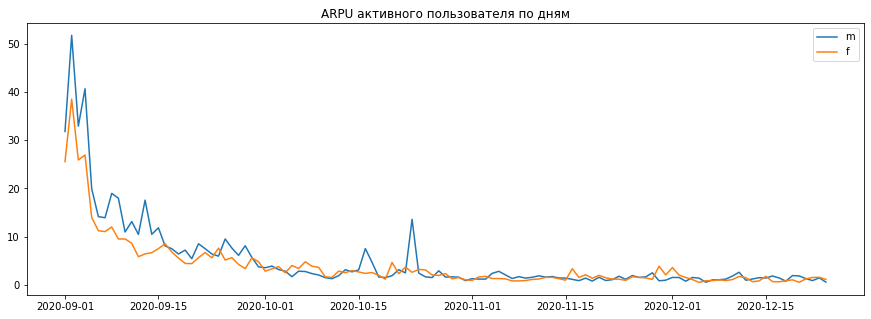

In [106]:
plt.figure(figsize=(15, 5))
plt.title('ARPU активного пользователя по дням')
plt.plot(m['date'],m['ARPU(all)'],label='m')
plt.plot(f['date'],f['ARPU(all)'],label='f')
plt.legend()
plt.show()

##### Распределение по возрасту

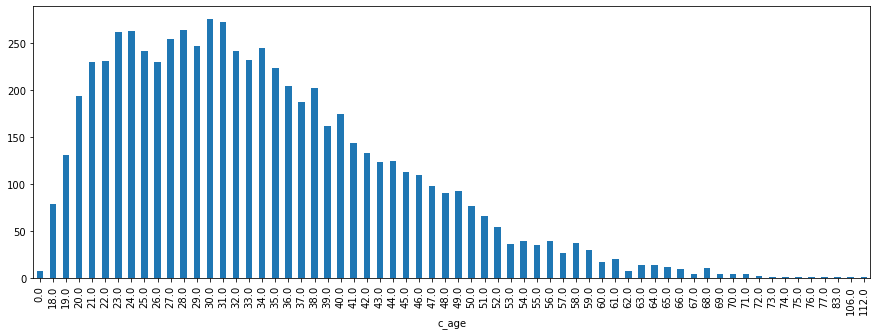

In [109]:
df.groupby(['c_age'])['rra_playerId'].nunique().plot.bar(figsize=(15,5))
plt.show()

In [117]:
tmp = date_user_active_joined_calc(df)

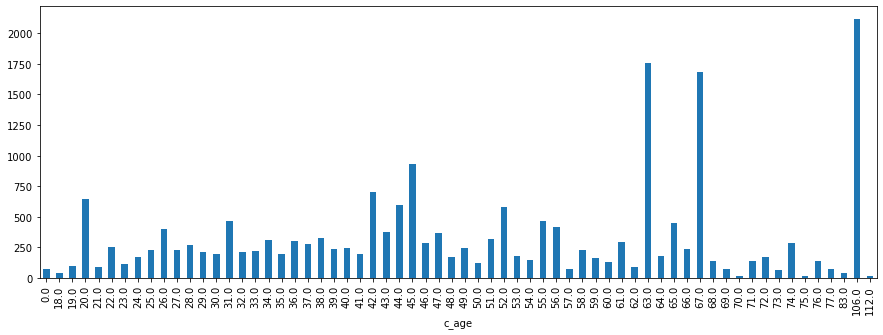

In [132]:
tmp.groupby(['rra_playerId','c_age'])[['depositsSumEur']].sum()\
.groupby('c_age')['depositsSumEur'].mean().plot.bar(figsize=(15,5))

##### Распределение по странам

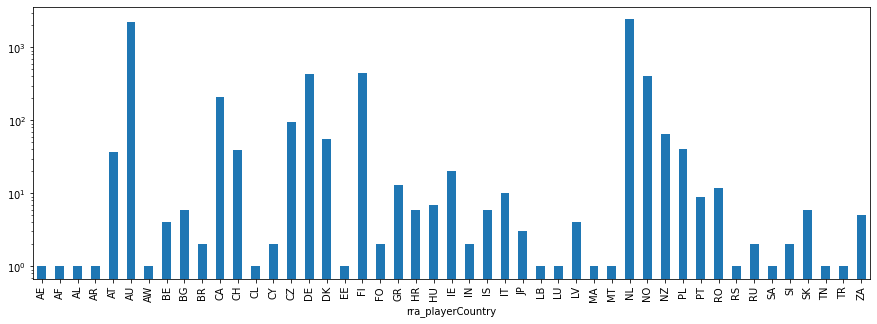

In [133]:
df.groupby(['rra_playerCountry'])['rra_playerId']\
.nunique()\
.plot.bar(figsize=(15,5),logy=True)

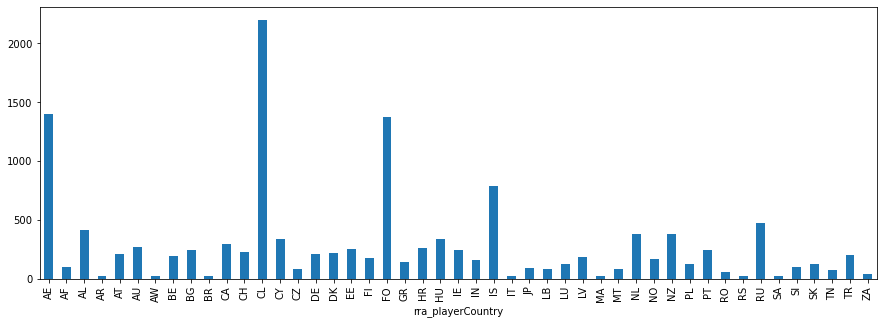

In [136]:
tmp.groupby(['rra_playerId','rra_playerCountry'])[['depositsSumEur']].sum()\
.groupby('rra_playerCountry')['depositsSumEur'].mean().plot.bar(figsize=(15,5))

### Рассчитать основные маркетинговые метрики (Churn rate, Retention, ARPWAU и пр.).

In [139]:
df2 = agregated(date_user_active_joined_calc(df))

In [142]:
df2[['date','cr_d','rr_d','cumulative_cr', 'cumulative_rr']]

,date,cr_d,rr_d,cumulative_cr,cumulative_rr
0,2020-09-01,NaN,NaN,NaN,NaN
1,2020-09-02,0.153846,0.846154,0.153846,0.846154
2,2020-09-03,0.293729,0.706271,0.302932,0.697068
3,2020-09-04,0.186879,0.813121,0.313758,0.686242
4,2020-09-05,0.150972,0.849028,0.336449,0.663551
...,...,...,...,...,...
110,2020-12-20,0.140097,0.859903,0.973144,0.026856
111,2020-12-21,0.120879,0.879121,0.975875,0.024125
112,2020-12-22,0.098765,0.901235,0.977992,0.022008
113,2020-12-23,0.194631,0.805369,0.981920,0.018080


# Задача 3 - Построение модели

### выдвинуть ряд гипотез от чего может зависеть depositsSum

1) от страны <br> 
2) от номера депозита (последующий депозит больше или меньше предыдущего)<br>
3) от пола<br>
4) от размера первого депозита <br>
5) от компании<br>

### проверить гипотезы на имеющихся данных,

##### Зависимость  depositsSum от страны

In [149]:
df.groupby('rra_playerCountry')[['rra_playerId','depositsSumEur']]\
.agg({'rra_playerId':'nunique','depositsSumEur':'mean'})\
.sort_values(ascending=False,by =  'rra_playerId').head()

,rra_playerId,depositsSumEur
rra_playerCountry,,
NL,2434,88.785206
AU,2247,55.163242
FI,442,65.424089
DE,437,69.398955
NO,404,50.597780


Чтобы проверить зависит ли depositsSumEur от страны проверим отличаются ли средние depositsSumEur в разных странах

In [150]:
#Выбираем данные по AU
au = df.loc[df['rra_playerCountry'] == 'AU',['depositsSumEur']]

In [151]:
#Выбираем данные по NL
nl = df.loc[df['rra_playerCountry'] == 'NL',['depositsSumEur']]

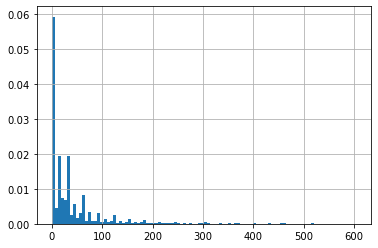

In [152]:
au.loc[(np.abs(stats.zscore(au['depositsSumEur'])) < 3),'depositsSumEur'].hist(bins = 100, density = True)

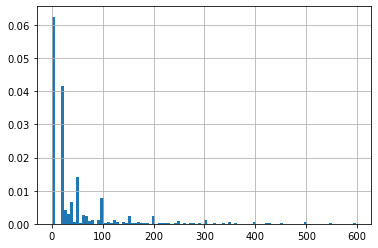

In [153]:
nl.loc[(np.abs(stats.zscore(nl['depositsSumEur'])) < 3)&(nl['depositsSumEur']<600),'depositsSumEur'].hist(bins = 100, density = True)

распределения depositsSumEur в  AU и NL имеют вид отличный от нормального

In [154]:
#добавляем поле со случайными значениями для сортировки по нему
au['order']=5000000
au['order'] = au['order'].apply(np.random.randint)

In [155]:
#добавляем поле со случайными значениями для сортировки по нему
nl['order']=5000000
nl['order'] = nl['order'].apply(np.random.randint)

In [156]:
#Функция разбивает датасет на подмножества по n,
#сортируюя данные о полю со случайными цифрами

def sub_means(s,n):
    s = s.sort_values('order')
    return [s[x:x+n] for x in range(0, len(s), n)]

In [157]:
#nl_means = [x['depositsSumEur'].mean() for x in sub_means(nl,200)]

In [158]:
#Разбиваем данные по AU на подывыборки и находим средние по ним 


au_means = [x['depositsSumEur'].mean() for x in sub_means(au,141)]

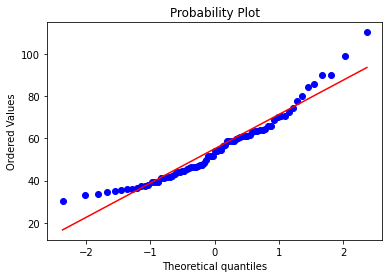

In [159]:
#Проверяем распределение средних по подвыборкам на нормальность

#measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(au_means, dist="norm", plot=pylab)
#stats.probplot(nl_means, dist="norm", plot=pylab)
pylab.show()

Распределение средних 'depositsSumEur' по подвыборкам из AU похоже на нормальное

In [131]:
stats.norm.ppf(0.95)

1.6448536269514722

In [132]:
np.mean(au_means)+1.959963984540054*np.std(au_means) < nl['depositsSumEur'].mean()

True

Средний значение депозита по стране AU + 1.65 стандартного отклонения меньше среднего значения деозита по NL, т.о. разности депозитов в странах NL и AU не отвергается

##### Зависимость от номера депозита (последующий деозит больше или меньше предыдущего)

In [161]:
df4 = df.loc[df['depositsSumEur']>0].sort_values('date')

In [162]:
df4['dep_num'] = df4.groupby('rra_playerId').cumcount()+1

In [163]:
dep= df4[['rra_playerId','dep_num','depositsSumEur']]\
.groupby('rra_playerId')\
.agg({'dep_num':'max','depositsSumEur':'count'}).reset_index()

In [164]:
dep_2 = dep.loc[dep['dep_num']==2,'rra_playerId']
dep_3 = dep.loc[dep['dep_num']==3,'rra_playerId']
dep_4 = dep.loc[dep['dep_num']==4,'rra_playerId']
#dep_5 = dep.loc[dep['dep_num']==5,'rra_playerId'] слишком мало

In [165]:
df4.loc[df4['rra_playerId'].isin(dep_2),['dep_num','depositsSumEur']].groupby('dep_num').mean()

,depositsSumEur
dep_num,
1,73.690251
2,74.470251


In [166]:
df4.loc[df4['rra_playerId'].isin(dep_3),['dep_num','depositsSumEur']].groupby('dep_num').mean()

,depositsSumEur
dep_num,
1,67.896950
2,59.065403
3,64.805098


In [167]:
df4.loc[df4['rra_playerId'].isin(dep_4),['dep_num','depositsSumEur']].groupby('dep_num').mean()

,depositsSumEur
dep_num,
1,74.753146
2,91.936808
3,88.123380
4,90.708638


Скорее всего, зависимости нет

In [168]:
df4.loc[df4['rra_playerId'].isin(dep_2),['dep_num','depositsSumEur']].groupby('dep_num').std()

,depositsSumEur
dep_num,
1,193.098236
2,152.018875


Статистически значимых различий в между первой и второй суммой депозитов нет, тк разница меньше стандартного отклонения

##### Зависимость от пола

In [204]:
gender = pd.DataFrame(df.groupby(['date','c_gender'])['depositsSumEur'].sum()\
/df.groupby(['date','c_gender'])['rra_playerId'].nunique())\
.reset_index().pivot(index='date',columns='c_gender', values=0)#.plot(figsize=(15,5))

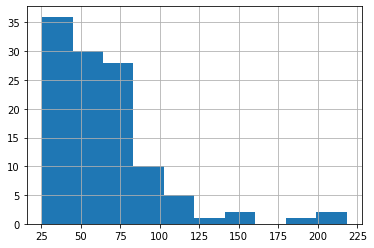

In [208]:
gender['f'].

In [239]:
f = gender[['f']]

In [242]:
#добавляем поле со случайными значениями для сортировки по нему
f['order']=5000000
f['order'] = f['order'].apply(np.random.randint)

In [247]:
#Разбиваем данные по AU на подывыборки и находим средние по ним 


f_subs = [x['f'].mean() for x in sub_means(f,5)]

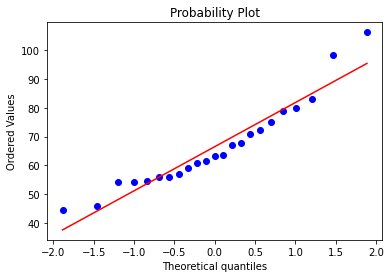

In [248]:
#Проверяем распределение средних по подвыборкам на нормальность

#measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(f_subs, dist="norm", plot=pylab)
#stats.probplot(nl_means, dist="norm", plot=pylab)
pylab.show()

In [254]:
np.mean(f_subs)+1.65*np.std(f_subs) < gender['m'].mean()

True

Можно полагать что зависимость есть

#### Зависимость от первого депозита

In [142]:
first_dep = df.groupby('rra_playerId')[['firstDepositsSumEur']].max()

In [143]:
avg_dep = df.loc[(df['firstDepositsSumEur']==0)&(df['depositsSumEur']!=0)].groupby('rra_playerId')[['depositsSumEur']].mean()

In [144]:
pd.merge(first_dep,avg_dep, left_on = 'rra_playerId', right_on = 'rra_playerId').corr()

,firstDepositsSumEur,depositsSumEur
firstDepositsSumEur,1.000000,0.193284
depositsSumEur,0.193284,1.000000


Коефициент корреляции между рядами невелик, признаков зависимсти нет

#####  Зависимость от кампании

In [145]:
df.loc[df['rra_playerCountry']=='AU']\
.groupby('rra_campaignId')[['depositsSumEur','rra_playerId']]\
.agg({'depositsSumEur':'mean','rra_playerId':'nunique'})\
.sort_values(by='rra_playerId', ascending = False).head(5)

,depositsSumEur,rra_playerId
rra_campaignId,,
93298,34.614343,181
101687,47.707474,177
93570,51.440046,150
94555,39.634878,136
94554,51.681270,134


In [146]:
#Выбираем данные по кампании 93298
c_93298 = df.loc[df['rra_campaignId'] == 93298 ,['depositsSumEur']]

In [147]:
#Выбираем данные по кампании 93570
c_93570 = df.loc[df['rra_campaignId'] == 93570 ,['depositsSumEur']]

In [148]:
#добавляем поле со случайными значениями для сортировки по нему
c_93298['order']=5000000
c_93298['order'] = c_93298['order'].apply(np.random.randint)

In [149]:
#добавляем поле со случайными значениями для сортировки по нему
c_93570['order']=5000000
c_93570['order'] = c_93570['order'].apply(np.random.randint)

In [150]:
#Функция разбивает датасет на подмножества по n,
#сортируюя данные о полю со случайными цифрами

def sub_means(s,n):
    s = s.sort_values('order')
    return [s[x:x+n] for x in range(0, len(s), n)]

In [151]:
#Разбиваем данные по AU на подывыборки и находим средние по ним 
c_93570 = [x['depositsSumEur'].mean() for x in sub_means(c_93570,8)]

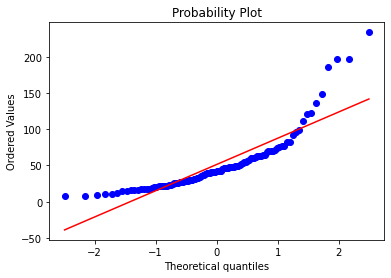

In [152]:
#measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(c_93570, dist="norm", plot=pylab)
#stats.probplot(nl_means, dist="norm", plot=pylab)
pylab.show()

Не очень похоже на нормальное распределение но имеем то что чт имеем

In [153]:
np.mean(c_93570)-1.959963984540054*np.std(c_93570),np.mean(c_93570)+1.959963984540054*np.std(c_93570)

(-27.867858613716287, 130.74787827295611)

Доверительный интервал очень большой, статистически значимые различия между данной кампанией и другими кампаниями с достаточным числом игроков не наблюдаются